In [80]:
import os

import polars as pl
import numpy as np

from datetime import datetime,timedelta
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

from cipred.lu2019 import lu_fit, lu_pred_prime
from sklearn import metrics

import matplotlib.pyplot as plt

In [2]:
import cipred

In [3]:
cipred.__version__

'0.3'

# Data

In [4]:
parent_dir = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))
data_dir = os.path.join(parent_dir,"data")

In [5]:
# read data

In [6]:
a = pl.read_csv(os.path.join(data_dir,'2015-2016.csv'),skip_rows=3)
b = pl.read_csv(os.path.join(data_dir,'2017-2018.csv'),skip_rows=3)
c = pl.read_csv(os.path.join(data_dir,'2019-2020.csv'),skip_rows=3)
d = pl.read_csv(os.path.join(data_dir,'2021-2022.csv'),skip_rows=3)

In [7]:
a.columns = b.columns = ['datetime',
              'alnabru', 'alnabru%',
              'bygdøyAlle', 'bygdøyAlle%', 
              'hjortnes','hjortnes%', 
              'kirkeveien', 'kirkeveien%',
              'manglerud', 'manglerud%',
              'akersykehus', 'akersykehus%',
              'smestad', 'smestad%', 
              'åkebergveien','åkebergveien%']
a = a.drop(columns=['alnabru%','bygdøyAlle%','hjortnes%','kirkeveien%','manglerud%','akersykehus%','smestad','smestad%','åkebergveien','åkebergveien%'])
b = b.drop(columns=['alnabru%','bygdøyAlle%','hjortnes%','kirkeveien%','manglerud%','akersykehus%','smestad','smestad%','åkebergveien','åkebergveien%'])
c.columns = ['datetime',
              'alnabru', 'alnabru%',
              'bygdøyAlle', 'bygdøyAlle%', 
              'hjortnes','hjortnes%', 
              'kirkeveien', 'kirkeveien%',
              'manglerud', 'manglerud%',
              'akersykehus', 'akersykehus%',
              'åkebergveien','åkebergveien%']
c = c.drop(columns=['alnabru%','bygdøyAlle%','hjortnes%','kirkeveien%','manglerud%','akersykehus%','åkebergveien','åkebergveien%'])
d.columns = ['datetime',
              'alnabru', 'alnabru%',
              'bygdøyAlle', 'bygdøyAlle%', 
              'hjortnes','hjortnes%', 
              'kirkeveien', 'kirkeveien%',
              'manglerud', 'manglerud%',
              'akersykehus', 'akersykehus%']

d = d.drop(columns=['alnabru%','bygdøyAlle%','hjortnes%','kirkeveien%','manglerud%','akersykehus%'])

/tmp/ipykernel_12010/897813374.py:10: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  a = a.drop(columns=['alnabru%','bygdøyAlle%','hjortnes%','kirkeveien%','manglerud%','akersykehus%','smestad','smestad%','åkebergveien','åkebergveien%'])
/tmp/ipykernel_12010/897813374.py:11: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  b = b.drop(columns=['alnabru%','bygdøyAlle%','hjortnes%','kirkeveien%','manglerud%','akersykehus%','smestad','smestad%','åkebergveien','åkebergveien%'])
/tmp/ipykernel_12010/897813374.py:20: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  c = c.drop(columns=['alnabru%','bygdøyAlle%','hjortnes%','kirkeveien%','manglerud%','akersykehus%','åkebergveien','åkebergveien%'])
/tmp/ipykernel_12010/897813374.py:29: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  d = d.drop(columns=['alnabru%','bygdøyAlle%','

In [24]:
df = pl.concat((a,b,c,d),how= 'vertical')

In [25]:
# # only positive values
df = df.filter(
    (pl.col('alnabru') > 0) & (pl.col('bygdøyAlle') > 0) & (pl.col('hjortnes') > 0) & (pl.col('kirkeveien') > 0) & (pl.col('manglerud') > 0) & (pl.col('akersykehus') > 0) 
)

In [26]:
H = 10
lags = range(H+1)

past = df.select(
    df[col].shift(lag).alias(f'{col} (t-{lag})')
    for col in df.columns if col != 'datetime'
    for  lag in lags
)

future = df.select(
    df[col].shift(-lag).alias(f'{col} (t+{lag})')
    for col in df.columns if col != 'datetime'
    for  lag in lags
)

In [27]:
df = pl.concat([df,past,future],how='horizontal').drop_nulls()

In [28]:
target = [f'kirkeveien (t+{i})' for i in range(1,H)]
# predictors = ['bygdøyAlle','hjortnes','alnabru','manglerud','akersykehus'] 
predictors = [f'kirkeveien (t-{i})' for i in range(H,0,-1)]

In [29]:
df = df.with_columns(pl.col("datetime").str.strptime(pl.Datetime, format="%d.%m.%Y %H:%M"))

In [30]:
# # Training/Test period 2015-2021
train_test = df.filter(
    pl.col("datetime") < datetime(2022, 1, 1),
)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(train_test[predictors], train_test[target], test_size=0.2, random_state=42)

# Train/Test

In [32]:
## model
# Number of variables to possibly split at in each node: rounded down square root of the number variables. 
min_samples_split= np.floor(np.sqrt(len(predictors))).astype(np.int64)

# Minimal node size. Default 1 for classification, 5 for regression, 3 for survival,
min_samples_leaf=5

In [33]:
rf_reg = RandomForestRegressor(n_estimators = 200, 
                               min_samples_split= min_samples_split,
                               min_samples_leaf=min_samples_leaf, 
                               #max_depth=4,
                               #random_state=0,
                               n_jobs=2) 

In [34]:
## Training 
rf_reg, train_oob_error = lu_fit(rf_reg, X_train.to_numpy(), y_train.to_numpy())

# Illustration

In [145]:
e = pl.read_csv(os.path.join(data_dir,'20161203-20161209_original.csv'),skip_rows=3)

In [146]:
e = e.drop(columns=['Til-tid','QA','QC','QA_duplicated_0','QC_duplicated_0','QA_duplicated_1','QC_duplicated_1','QA_duplicated_2','QC_duplicated_2','QA_duplicated_3','QC_duplicated_3','QA_duplicated_4','QC_duplicated_4'])
e.columns = ['datetime',
              'alnabru', 
              'bygdøyAlle',
              'hjortnes',
              'kirkeveien',
              'manglerud',
              'akersykehus']

/tmp/ipykernel_12010/215827567.py:1: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  e = e.drop(columns=['Til-tid','QA','QC','QA_duplicated_0','QC_duplicated_0','QA_duplicated_1','QC_duplicated_1','QA_duplicated_2','QC_duplicated_2','QA_duplicated_3','QC_duplicated_3','QA_duplicated_4','QC_duplicated_4'])


In [147]:
# # only positive values
e = e.filter(
    (pl.col('alnabru') > 0) & (pl.col('bygdøyAlle') > 0) & (pl.col('hjortnes') > 0) & (pl.col('kirkeveien') > 0) & (pl.col('manglerud') > 0) & (pl.col('akersykehus') > 0) 
)

In [148]:
e = e.with_columns(pl.col("datetime").str.strptime(pl.Datetime, format="%d.%m.%Y %H:%M"))

In [149]:
H = 10
lags = range(H+1)

past = e.select(
    e[col].shift(lag).alias(f'{col} (t-{lag})')
    for col in e.columns if col != 'datetime'
    for  lag in lags
)

future = e.select(
    e[col].shift(-lag).alias(f'{col} (t+{lag})')
    for col in e.columns if col != 'datetime'
    for  lag in lags
)

In [150]:
e = pl.concat([e,past,future],how='horizontal').drop_nulls()

In [151]:
# between 4 December 2016 and 8 December 2016
X_illustration = e[predictors]
y_illustration = e[target]

In [152]:
tmp_illustration = lu_pred_prime(rf_reg,train_oob_error,X_illustration.to_numpy(),y_illustration.to_numpy(),0.10)

In [153]:
tmp_illustration.shape

(142, 57)

In [154]:
tmp_illustration = pl.concat((tmp_illustration,e),how='horizontal')


In [155]:
illustration_pd = tmp_illustration.to_pandas().set_index('datetime')

## Prediction at time t+1 and observation, only

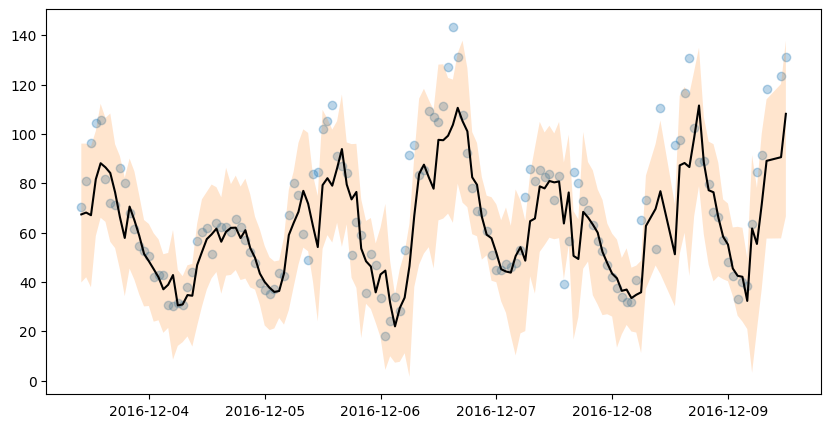

In [156]:

fig, axs = plt.subplots(figsize=(10, 5))

axs.scatter(illustration_pd.index, illustration_pd['obs_0'].values,alpha=0.3)
axs.fill_between(illustration_pd.index, illustration_pd['N_0_0.05'], illustration_pd['N_0_0.95'], alpha=0.2)
axs.plot(illustration_pd.index, 'pred_0', data=illustration_pd, color='black')
plt.show()

## Prediction from  time (2016, 12, 3, 10, 0) 1 to time + H and observation

In [157]:
output = {}
output.update({
    'pred' : tmp_illustration[0].select([f'pred_{i}' for i in range(1,H-1)]).transpose(include_header=False, column_names=['pred']),
    'obs' : tmp_illustration[0].select([f'obs_{i}' for i in range(1,H-1)]).transpose(include_header=False, column_names=['obs']),
    'N_0.05' : tmp_illustration[0].select([f'N_{i}_0.05' for i in range(1,H-1)]).transpose(include_header=False, column_names=['N_0.05']),
    'N_0.95' : tmp_illustration[0].select([f'N_{i}_0.95' for i in range(1,H-1)]).transpose(include_header=False, column_names=['N_0.95'])

})

In [158]:
output = pl.DataFrame(output)

In [159]:
start_date = tmp_illustration[0,'datetime']
end_date = start_date +  timedelta(hours=output.shape[0]-1)

In [160]:
start_date

datetime.datetime(2016, 12, 3, 10, 0)

In [161]:
output = output.with_columns(
    pl.datetime_range(start_date,end_date,timedelta(hours=1),time_unit="ms",eager=True).alias('datetime')
).to_pandas().set_index('datetime')

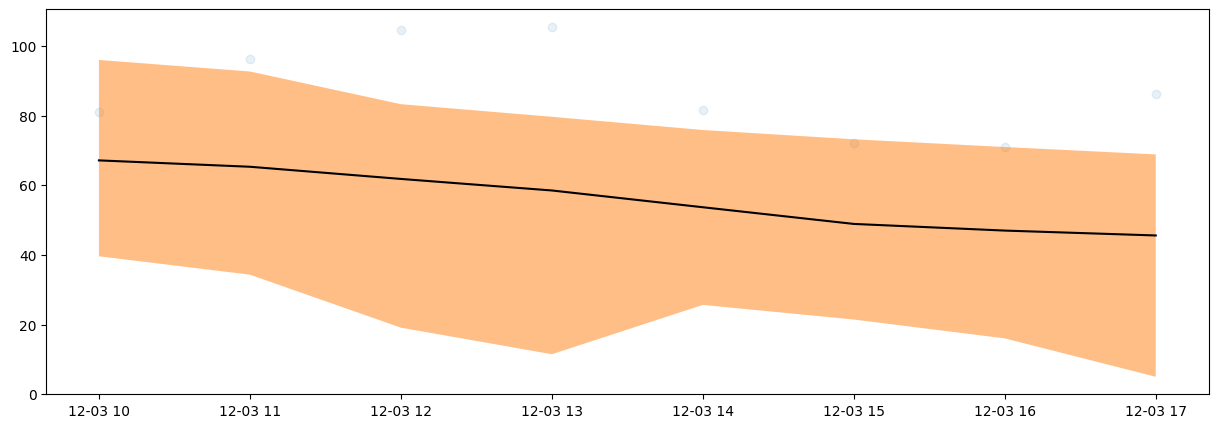

In [162]:
fig,axs = plt.subplots(figsize=(15,5))

axs.plot(output.index,output['pred'],color='black')
axs.scatter(output.index,output['obs'].values,alpha=0.1)
axs.fill_between(output.index,output['N_0.05'],output['N_0.95'],alpha=0.5)

plt.show()


## Prediction from  time (2016, 12, 3, 10, 0) 1 to time + H and observation

In [163]:
output = {}
output.update({
    'pred' : tmp_illustration[90].select([f'pred_{i}' for i in range(1,H-1)]).transpose(include_header=False, column_names=['pred']),
    'obs' : tmp_illustration[90].select([f'obs_{i}' for i in range(1,H-1)]).transpose(include_header=False, column_names=['obs']),
    'N_0.05' : tmp_illustration[90].select([f'N_{i}_0.05' for i in range(1,H-1)]).transpose(include_header=False, column_names=['N_0.05']),
    'N_0.95' : tmp_illustration[90].select([f'N_{i}_0.95' for i in range(1,H-1)]).transpose(include_header=False, column_names=['N_0.95'])

})

In [164]:
output = pl.DataFrame(output)

In [165]:
start_date = tmp_illustration[90,'datetime']
end_date = start_date +  timedelta(hours=output.shape[0]-1)

In [166]:
start_date

datetime.datetime(2016, 12, 7, 4, 0)

In [167]:
output = output.with_columns(
    pl.datetime_range(start_date,end_date,timedelta(hours=1),time_unit="ms",eager=True).alias('datetime')
).to_pandas().set_index('datetime')

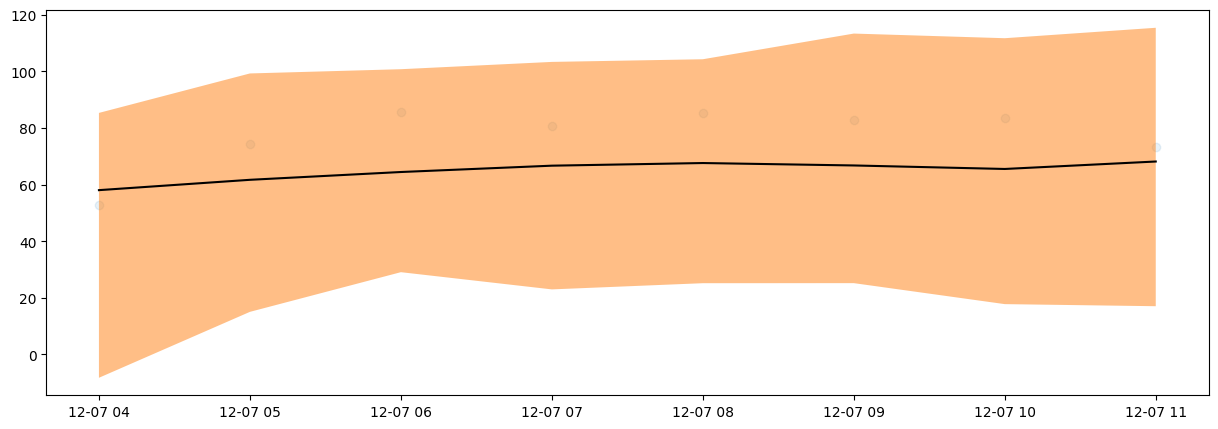

In [168]:
fig,axs = plt.subplots(figsize=(15,5))

axs.plot(output.index,output['pred'],color='black')
axs.scatter(output.index,output['obs'].values,alpha=0.1)
axs.fill_between(output.index,output['N_0.05'],output['N_0.95'],alpha=0.5)

plt.show()
